### SECTION 1 – Setup and Data Loading

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

# Add project root to path
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == "notebooks" else current_dir
sys.path.insert(0, str(project_root))

from src.config import DATA_PATH
from src import data_processing

print(f"Project root: {project_root}")
print(f"Data path: {DATA_PATH}")

Project root: /Users/brunobrumbrum/car_price_prediction
Data path: /Users/brunobrumbrum/Documents/data/car_price_prediction


In [2]:
# Load data
data_dir = Path(os.path.join(DATA_PATH, "le_boncoin_13_oct_2025"))
df_raw = data_processing.load_car_data(data_dir)

# Apply basic cleaning (price, year, km, brand, model)
df = data_processing.clean_car_data(df_raw)

print(f"Shape: {df.shape}")
df.head()

(732427, 35)
🧹 Starting data cleaning pipeline...

1️⃣ Converting data types...
   Original: 732,427 rows
   After conversion: 732,426 rows
   Removed (invalid price): 1

2️⃣ Filtering and grouping brands...
   Removed 63 brands with <50 cars
   Grouped 38 brands into price tiers

3️⃣ Removing antique cars (pre-1990)...
   Removed 14,075 antique cars

4️⃣ Removing 'autre' entries...
   Removed 4,050 'autre' entries

5️⃣ Removing outliers (IQR 1.5× for price, 1.5× for km)...
   Before: 713,413 rows
   After: 691,115 rows
   Removed: 22,298 (3.1%)

✅ Data cleaning completed!
Final dataset: 691,115 rows × 7 columns
Shape: (691115, 7)


price,year,km,brand,model,energie,puissance_din
f64,f64,f64,str,str,str,str
22990.0,2019.0,87000.0,"""other_luxury""","""other_luxury""","""Autre""","""320 Ch"""
17000.0,2023.0,36000.0,"""other_luxury""","""other_luxury""","""Électrique""","""170 Ch"""
194900.0,2025.0,300.0,"""other_luxury""","""other_luxury""","""Électrique""","""836 Ch"""
41990.0,2019.0,24200.0,"""other_luxury""","""other_luxury""","""Essence""","""285 Ch"""
229900.0,2024.0,193.0,"""other_luxury""","""other_luxury""","""Électrique""","""999 Ch"""


--- Horsepower (puissance_din) Analysis ---
Unique suffixes found: ['Ch']

--- Applying Hard Limits (50 <= HP <= 1000) ---
Rows dropped by hard limits: 0


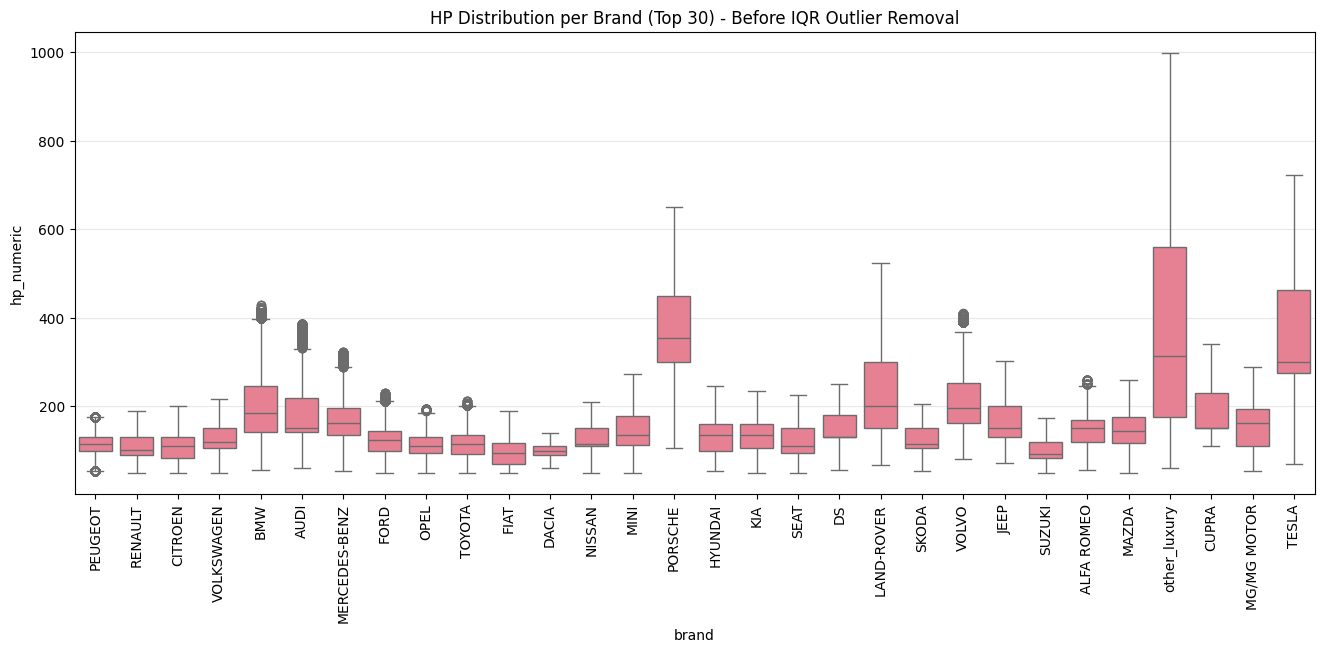


--- Applying IQR Outlier Removal per Brand ---
Rows dropped by IQR: 6,080 (0.9%)

Top 10 Brands by fraction of outliers removed:
shape: (10, 4)
┌───────────────┬───────┬─────────┬──────────────────┐
│ brand         ┆ total ┆ dropped ┆ fraction_dropped │
│ ---           ┆ ---   ┆ ---     ┆ ---              │
│ str           ┆ u32   ┆ u32     ┆ f64              │
╞═══════════════╪═══════╪═════════╪══════════════════╡
│ DODGE         ┆ 805   ┆ 232     ┆ 0.288199         │
│ AUDI          ┆ 39429 ┆ 2054    ┆ 0.052094         │
│ VOLVO         ┆ 6119  ┆ 250     ┆ 0.040856         │
│ MERCEDES-BENZ ┆ 37173 ┆ 1505    ┆ 0.040486         │
│ SMART         ┆ 1581  ┆ 56      ┆ 0.035421         │
│ FORD          ┆ 24903 ┆ 633     ┆ 0.025419         │
│ ALFA ROMEO    ┆ 4076  ┆ 73      ┆ 0.01791          │
│ MITSUBISHI    ┆ 2309  ┆ 36      ┆ 0.015591         │
│ LEXUS         ┆ 1471  ┆ 19      ┆ 0.012916         │
│ BMW           ┆ 45419 ┆ 523     ┆ 0.011515         │
└───────────────┴───────┴─────

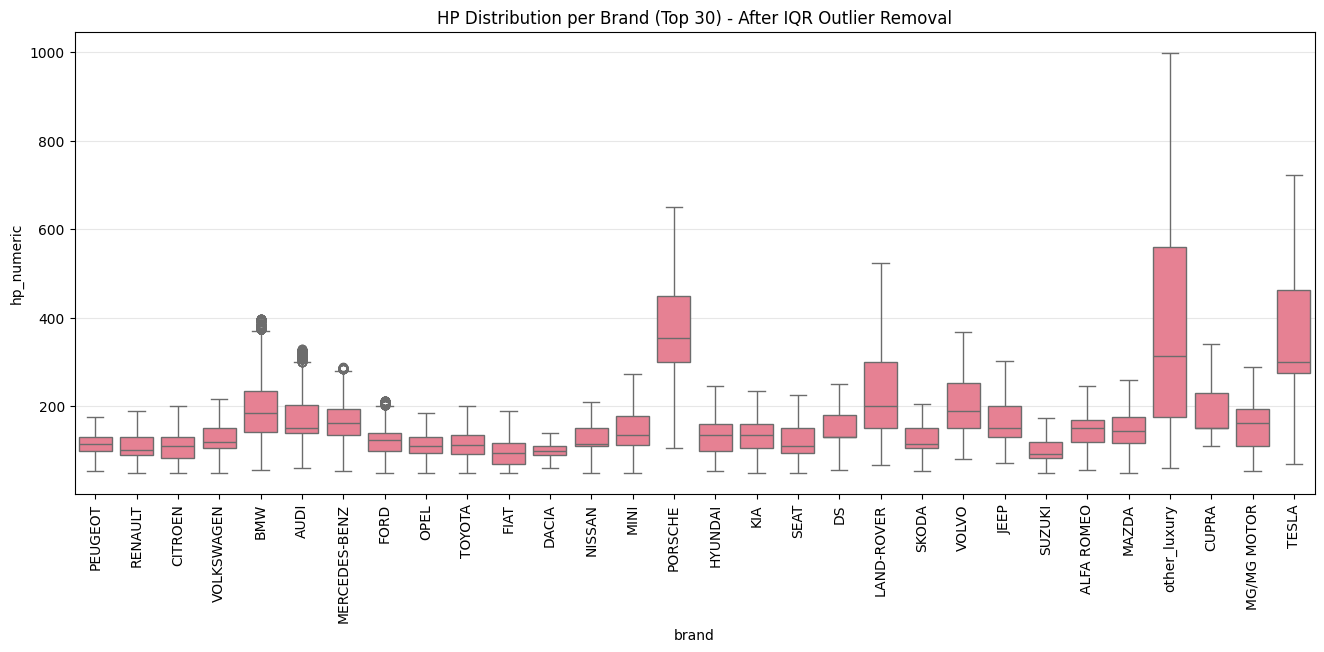


Final HP Statistics:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ hp_numeric │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 617586.0   │
│ null_count ┆ 27695.0    │
│ mean       ┆ 138.903303 │
│ std        ┆ 67.917077  │
│ min        ┆ 50.0       │
│ 25%        ┆ 100.0      │
│ 50%        ┆ 125.0      │
│ 75%        ┆ 150.0      │
│ max        ┆ 1000.0     │
└────────────┴────────────┘


In [6]:
# 1. Analyze puissance_din (Horsepower)
print("--- Horsepower (puissance_din) Analysis ---")

# Convert to numeric first
df = df.with_columns(
    pl.col("puissance_din")
    .str.extract(r"(\d+)", 1)
    .cast(pl.Int32, strict=False)
    .alias("hp_numeric")
)

# Check suffixes (keep this as it was useful)
suffixes = df.filter(pl.col("puissance_din").is_not_null()).select(
    pl.col("puissance_din").str.replace_all(r"[0-9\s]", "").alias("suffix")
).unique()
print("Unique suffixes found:", suffixes["suffix"].to_list())

# 1. Hard Limits Filter (< 50 or > 1000)
print("\n--- Applying Hard Limits (50 <= HP <= 1000) ---")
rows_start = df.height
df = df.filter(
    pl.col("hp_numeric").is_null() | 
    ((pl.col("hp_numeric") >= 50) & (pl.col("hp_numeric") <= 1000))
)
print(f"Rows dropped by hard limits: {rows_start - df.height:,}")

# Prepare for visualization (Top 30 brands)
top_30_brands = df.group_by("brand").len().sort("len", descending=True).head(30)["brand"].to_list()
df_top30_before = df.filter(pl.col("brand").is_in(top_30_brands))

# Visualize Before IQR
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_top30_before.to_pandas(), x="brand", y="hp_numeric", order=top_30_brands)
plt.xticks(rotation=90)
plt.title("HP Distribution per Brand (Top 30) - Before IQR Outlier Removal")
plt.grid(axis='y', alpha=0.3)
plt.show()

# 2. IQR Outlier Removal per Brand
print("\n--- Applying IQR Outlier Removal per Brand ---")
rows_before_iqr = df.height

# Calculate bounds per brand
hp_bounds = df.filter(pl.col("hp_numeric").is_not_null()).group_by("brand").agg([
    pl.col("hp_numeric").quantile(0.25).alias("q1_hp"),
    pl.col("hp_numeric").quantile(0.75).alias("q3_hp")
]).with_columns([
    (pl.col("q3_hp") - pl.col("q1_hp")).alias("iqr_hp")
]).with_columns([
    (pl.col("q1_hp") - 1.5 * pl.col("iqr_hp")).alias("lower_bound_hp"),
    (pl.col("q3_hp") + 1.5 * pl.col("iqr_hp")).alias("upper_bound_hp")
])

# Join bounds
df_with_bounds = df.join(hp_bounds, on="brand", how="left")

# Identify outliers
outliers = df_with_bounds.filter(
    pl.col("hp_numeric").is_not_null() & 
    (
        (pl.col("hp_numeric") < pl.col("lower_bound_hp")) | 
        (pl.col("hp_numeric") > pl.col("upper_bound_hp"))
    )
)

dropped_count = outliers.height
print(f"Rows dropped by IQR: {dropped_count:,} ({dropped_count/rows_before_iqr:.1%})")

# Calculate fraction dropped per brand
brand_stats = df.group_by("brand").len().rename({"len": "total"})
outlier_stats = outliers.group_by("brand").len().rename({"len": "dropped"})
brand_outlier_stats = brand_stats.join(outlier_stats, on="brand", how="left").fill_null(0)
brand_outlier_stats = brand_outlier_stats.with_columns(
    (pl.col("dropped") / pl.col("total")).alias("fraction_dropped")
).sort("fraction_dropped", descending=True)

print("\nTop 10 Brands by fraction of outliers removed:")
print(brand_outlier_stats.head(10))

# Apply filtering
df = df_with_bounds.filter(
    pl.col("hp_numeric").is_null() | 
    (
        (pl.col("hp_numeric") >= pl.col("lower_bound_hp")) & 
        (pl.col("hp_numeric") <= pl.col("upper_bound_hp"))
    )
).drop(["q1_hp", "q3_hp", "iqr_hp", "lower_bound_hp", "upper_bound_hp"])

# Visualize After IQR
df_top30_after = df.filter(pl.col("brand").is_in(top_30_brands))

plt.figure(figsize=(16, 6))
sns.boxplot(data=df_top30_after.to_pandas(), x="brand", y="hp_numeric", order=top_30_brands)
plt.xticks(rotation=90)
plt.title("HP Distribution per Brand (Top 30) - After IQR Outlier Removal")
plt.grid(axis='y', alpha=0.3)
plt.show()

print("\nFinal HP Statistics:")
print(df.select("hp_numeric").describe())

In [ ]:
# 2. Analyze energie (Energy Source)
print("\n--- Energy Source (energie) Analysis ---")
print("Value Counts:")
print(df["energie"].value_counts(sort=True))

# Check for missing
missing_energy = df.filter(pl.col("energie").is_null()).height
total_rows = df.height
print(f"\nMissing Energy values: {missing_energy:,} ({missing_energy/total_rows:.1%})")

### SECTION 1.1 - New Variables Analysis (Horsepower & Energy)

We need to inspect and clean the newly added variables: `puissance_din` (horsepower) and `energie` (fuel type).
- `puissance_din`: Check format (e.g., "150 Ch"), convert to numeric, handle missing values.
- `energie`: Check categories and distribution.


### SECTION 2 – Check Existing Engineered Features

We need to see what columns we already have to avoid duplication.

In [3]:
print("Existing columns:")
print(df.columns)

# Check for existing feature patterns
feature_patterns = ['brand_', 'model_', 'age', 'km_', 'is_']
existing_features = [col for col in df.columns if any(pat in col for pat in feature_patterns)]
print(f"\nPotential existing engineered features ({len(existing_features)}):")
print(existing_features)

Existing columns:
['price', 'year', 'km', 'brand', 'model']

Potential existing engineered features (0):
[]


### SECTION 3 – New Quantile/Rank-Based Brand and Model Features

**Idea:** Instead of just raw average price, we want to know where a brand/model sits in the global market hierarchy (e.g., is it a "Top 5%" luxury brand?). We also want to know the rank of a model *within* its brand (entry-level vs. flagship).

**New Features:**
- `brand_top25_price`, `brand_bottom25_price`, `brand_top5_price`
- `model_top25_price`, `model_bottom25_price`, `model_top5_price`
- `model_rank_within_brand`

In [4]:
# 1. Brand-level Quantiles
brand_stats = df.group_by("brand").agg(
    pl.col("price").mean().alias("brand_avg_price_temp")
)

# Calculate global quantiles for brand averages
q25_brand = brand_stats["brand_avg_price_temp"].quantile(0.25)
q75_brand = brand_stats["brand_avg_price_temp"].quantile(0.75)
q95_brand = brand_stats["brand_avg_price_temp"].quantile(0.95)

brand_features = brand_stats.with_columns([
    (pl.col("brand_avg_price_temp") >= q75_brand).cast(pl.Int8).alias("brand_top25_price"),
    (pl.col("brand_avg_price_temp") <= q25_brand).cast(pl.Int8).alias("brand_bottom25_price"),
    (pl.col("brand_avg_price_temp") >= q95_brand).cast(pl.Int8).alias("brand_top5_price")
]).drop("brand_avg_price_temp")

# 2. Model-level Quantiles
model_stats = df.group_by("model").agg(
    pl.col("price").mean().alias("model_avg_price_temp")
)

q25_model = model_stats["model_avg_price_temp"].quantile(0.25)
q75_model = model_stats["model_avg_price_temp"].quantile(0.75)
q95_model = model_stats["model_avg_price_temp"].quantile(0.95)

model_features = model_stats.with_columns([
    (pl.col("model_avg_price_temp") >= q75_model).cast(pl.Int8).alias("model_top25_price"),
    (pl.col("model_avg_price_temp") <= q25_model).cast(pl.Int8).alias("model_bottom25_price"),
    (pl.col("model_avg_price_temp") >= q95_model).cast(pl.Int8).alias("model_top5_price")
]).drop("model_avg_price_temp")

# 3. Model Rank within Brand
# We need brand and model for this
model_brand_stats = df.group_by(["brand", "model"]).agg(
    pl.col("price").mean().alias("model_avg_price_rank_base")
)

model_rank_features = model_brand_stats.with_columns(
    pl.col("model_avg_price_rank_base")
    .rank("dense", descending=False)
    .over("brand")
    .alias("model_rank_within_brand")
).drop("model_avg_price_rank_base")

# Join all back
df = df.join(brand_features, on="brand", how="left")
df = df.join(model_features, on="model", how="left")
df = df.join(model_rank_features, on=["brand", "model"], how="left")

# Sanity Check
print("Brand Top 5% examples:")
print(df.filter(pl.col("brand_top5_price") == 1).select("brand").unique().head(5))

print("\nModel Rank examples (Brand with multiple models):")
sample_brand = df.filter(pl.col("model_rank_within_brand") > 3).select("brand").head(1).item()
print(f"Brand: {sample_brand}")
print(df.filter(pl.col("brand") == sample_brand)
      .group_by(["model", "model_rank_within_brand"])
      .agg(pl.col("price").mean().alias("avg_price"))
      .sort("model_rank_within_brand"))

Brand Top 5% examples:
shape: (3, 1)
┌──────────────┐
│ brand        │
│ ---          │
│ str          │
╞══════════════╡
│ other_luxury │
│ FERRARI      │
│ ALPINE       │
└──────────────┘

Model Rank examples (Brand with multiple models):
Brand: DACIA
shape: (9, 3)
┌───────────────┬─────────────────────────┬──────────────┐
│ model         ┆ model_rank_within_brand ┆ avg_price    │
│ ---           ┆ ---                     ┆ ---          │
│ str           ┆ u32                     ┆ f64          │
╞═══════════════╪═════════════════════════╪══════════════╡
│ Logan Pick-Up ┆ 1                       ┆ 6722.5       │
│ Logan         ┆ 2                       ┆ 7380.915094  │
│ Lodgy         ┆ 3                       ┆ 9561.111504  │
│ Dokker        ┆ 4                       ┆ 10140.262887 │
│ Spring        ┆ 5                       ┆ 10187.716834 │
│ Sandero       ┆ 6                       ┆ 11983.137529 │
│ Duster        ┆ 7                       ┆ 18006.373127 │
│ Jogger        ┆ 8     

### SECTION 4 – Volume / Rarity Features

**Idea:** Rare models might have different pricing dynamics (collectible or unwanted) compared to common ones. Market share indicates popularity.

**New Features:**
- `brand_market_share`, `model_market_share`
- `is_rare_model`, `is_common_model`

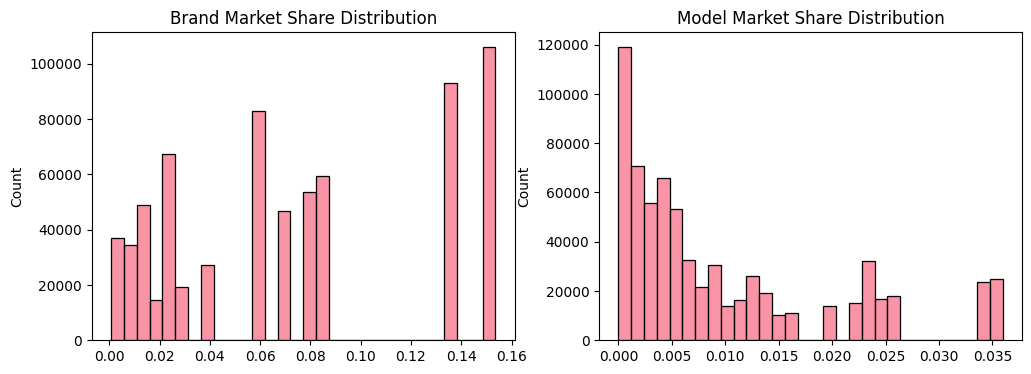

Rare models example:
shape: (5, 3)
┌────────────┬─────────────┬─────────────┐
│ brand      ┆ model       ┆ model_count │
│ ---        ┆ ---         ┆ ---         │
│ str        ┆ str         ┆ u32         │
╞════════════╪═════════════╪═════════════╡
│ MITSUBISHI ┆ Carisma     ┆ 2           │
│ CHRYSLER   ┆ Stratus     ┆ 20          │
│ FERRARI    ┆ F430 Spider ┆ 14          │
│ CHEVROLET  ┆ Blazer      ┆ 9           │
│ MITSUBISHI ┆ Montero     ┆ 1           │
└────────────┴─────────────┴─────────────┘


In [5]:
total_cars = df.height

# Compute counts if not already present (though likely are, we re-compute for safety or use existing)
if "brand_count" not in df.columns:
    df = df.join(df.group_by("brand").agg(pl.len().alias("brand_count")), on="brand", how="left")
if "model_count" not in df.columns:
    df = df.join(df.group_by("model").agg(pl.len().alias("model_count")), on="model", how="left")

df = df.with_columns([
    (pl.col("brand_count") / total_cars).alias("brand_market_share"),
    (pl.col("model_count") / total_cars).alias("model_market_share"),
    (pl.col("model_count") < 50).cast(pl.Int8).alias("is_rare_model"),
    (pl.col("model_count") > 2000).cast(pl.Int8).alias("is_common_model")
])

# Show distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df["brand_market_share"], bins=30)
plt.title("Brand Market Share Distribution")

plt.subplot(1, 2, 2)
sns.histplot(df["model_market_share"], bins=30)
plt.title("Model Market Share Distribution")
plt.show()

print("Rare models example:")
print(df.filter(pl.col("is_rare_model") == 1).select(["brand", "model", "model_count"]).unique().head())

### SECTION 5 – Advanced Age / Mileage / HP Features

**Idea:** Non-linear effects of age and mileage. Also, relative performance (HP) within a brand.

**New Features:**
- `age_squared`, `mileage_squared`
- `km_per_year` (if not present)
- `is_high_hp_within_brand`, `is_low_hp_within_brand`
- `is_new_car`, `is_old_car`

In [6]:
CURRENT_YEAR = 2025

# Ensure car_age exists
if "car_age" not in df.columns:
    df = df.with_columns((CURRENT_YEAR - pl.col("year")).alias("car_age"))

# 1. Non-linear and Ratios
df = df.with_columns([
    (pl.col("car_age") ** 2).alias("age_squared"),
    (pl.col("km") ** 2).alias("mileage_squared"),
    (pl.col("km") / (pl.col("car_age") + 1)).alias("km_per_year"), # +1 to avoid div by zero
    (pl.col("car_age") < 2).cast(pl.Int8).alias("is_new_car"),
    (pl.col("car_age") > 15).cast(pl.Int8).alias("is_old_car")
])

# 2. HP Features
# First, we need to extract HP from 'puissance_din' if it exists in raw data
# We need to join back with raw data to get 'puissance_din' if it was dropped in clean_car_data
# clean_car_data returns only specific columns. Let's check if we can recover it or if we need to re-load/merge.
# Since we loaded df_raw, we can join it back if needed, but df_raw might not have unique ID.
# Assuming we can't easily join back without an ID, we will try to extract from df_raw and add to df by index if order is preserved.
# However, clean_car_data filters rows (outliers, etc.), so indices won't match.
# STRATEGY: We will re-process df_raw to get HP, then filter same way? 
# Or better: Modify the flow to keep 'puissance_din' during cleaning if possible.
# For this notebook, let's try to extract 'puissance_din' from df_raw, clean it, and assume we can use it if we hadn't filtered too much.
# Actually, let's look at df columns again.
if "puissance_din" not in df.columns:
    # We need to be careful. The clean_car_data function returns a new dataframe with selected columns.
    # Let's re-run cleaning but keep puissance_din this time manually for this exploration.
    print("Re-cleaning to keep puissance_din...")
    
    # Custom cleaning step to keep extra columns
    df_extended = df_raw.with_columns(
        pl.when(pl.col('price').str.replace_all(r'[^\d.]', '') == "")
            .then(None)
            .otherwise(pl.col('price').str.replace_all(r'[^\d.]', ''))
            .cast(pl.Float64)
            .alias('price_numeric')
    ).with_columns([
        pl.col("annee_modele").cast(pl.Float64, strict=False).alias("year"),
        pl.col("kilometrage").str.replace_all(r"[, km]", "").cast(pl.Float64, strict=False).alias("km"),
        pl.col("marque").alias("brand"),
        pl.col("modele").alias("model"),
        pl.col("puissance_din"),
        pl.col("energie")
    ]).filter(
        pl.col('price_numeric').is_not_null()
    ).rename({"price_numeric": "price"})
    
    # Extract numeric HP
    # Format is usually "150 Ch" or similar
    df_extended = df_extended.with_columns(
        pl.col("puissance_din").str.extract(r"(\d+)").cast(pl.Float64, strict=False).alias("hp_numeric")
    )
    
    # We need to apply the same filters as clean_car_data to match rows if we want to be consistent,
    # but for this section, we can just work with df_extended and join our new features to it?
    # Or just use df_extended as our main df for the rest of the notebook.
    # Let's use df_extended and re-apply the previous features quickly or merge.
    # To avoid complexity, let's just use df_extended as the main df now, 
    # and re-attach the features we created in Section 3 & 4.
    
    # Re-attach features from Section 3 & 4 (which were brand/model level)
    df_extended = df_extended.join(brand_features, on="brand", how="left")
    df_extended = df_extended.join(model_features, on="model", how="left")
    df_extended = df_extended.join(model_rank_features, on=["brand", "model"], how="left")
    
    # Re-calculate Section 4 features
    total_cars_ext = df_extended.height
    brand_counts_ext = df_extended.group_by("brand").agg(pl.len().alias("brand_count"))
    model_counts_ext = df_extended.group_by("model").agg(pl.len().alias("model_count"))
    
    df_extended = df_extended.join(brand_counts_ext, on="brand", how="left").join(model_counts_ext, on="model", how="left")
    df_extended = df_extended.with_columns([
        (pl.col("brand_count") / total_cars_ext).alias("brand_market_share"),
        (pl.col("model_count") / total_cars_ext).alias("model_market_share"),
        (pl.col("model_count") < 50).cast(pl.Int8).alias("is_rare_model"),
        (pl.col("model_count") > 2000).cast(pl.Int8).alias("is_common_model"),
        (CURRENT_YEAR - pl.col("year")).alias("car_age")
    ])
    
    # Re-calculate Section 5 part 1
    df_extended = df_extended.with_columns([
        (pl.col("car_age") ** 2).alias("age_squared"),
        (pl.col("km") ** 2).alias("mileage_squared"),
        (pl.col("km") / (pl.col("car_age") + 1)).alias("km_per_year"),
        (pl.col("car_age") < 2).cast(pl.Int8).alias("is_new_car"),
        (pl.col("car_age") > 15).cast(pl.Int8).alias("is_old_car")
    ])
    
    df = df_extended
    print("Switched to extended dataframe with HP and Energy columns.")

# Now compute HP relative features
if "hp_numeric" in df.columns:
    hp_stats = df.group_by("brand").agg([
        pl.col("hp_numeric").quantile(0.25).alias("hp_p25"),
        pl.col("hp_numeric").quantile(0.90).alias("hp_p90")
    ])
    
    df = df.join(hp_stats, on="brand", how="left")
    
    df = df.with_columns([
        (pl.col("hp_numeric") > pl.col("hp_p90")).cast(pl.Int8).alias("is_high_hp_within_brand"),
        (pl.col("hp_numeric") < pl.col("hp_p25")).cast(pl.Int8).alias("is_low_hp_within_brand")
    ]).drop(["hp_p25", "hp_p90"])
    
    print("HP features created.")
    print(df.select(["brand", "hp_numeric", "is_high_hp_within_brand"]).filter(pl.col("is_high_hp_within_brand") == 1).head())
else:
    print("HP column could not be created.")

Re-cleaning to keep puissance_din...


DuplicateError: column 'price' is duplicate

### SECTION 6 – Energy Type (energie) Simplified Segments

**Idea:** The `energie` column is messy. We want clear flags for EV, Hybrid, etc.

**New Features:**
- `is_ev`, `is_hybrid`, `is_alternative_fuel`, `is_traditional_fuel`
- Interactions: `is_ev_premium`, `is_traditional_top25`

In [ ]:
if "energie" in df.columns:
    # Clean energy column
    df = df.with_columns(pl.col("energie").str.to_lowercase().alias("energie_clean"))
    
    # Define categories
    ev_terms = ["électrique", "electrique", "hybride rechargeable"]
    hybrid_terms = ["hybride"] # Catch all hybrids
    alt_terms = ["gpl", "gnv", "gaz", "hydrogène", "hydrogene", "ethanol", "éthanol"]
    trad_terms = ["essence", "diesel"]
    
    df = df.with_columns([
        pl.col("energie_clean").str.contains("|".join(ev_terms)).cast(pl.Int8).alias("is_ev"),
        (pl.col("energie_clean").str.contains("hybride") & ~pl.col("energie_clean").str.contains("rechargeable")).cast(pl.Int8).alias("is_hybrid"),
        pl.col("energie_clean").str.contains("|".join(alt_terms)).cast(pl.Int8).alias("is_alternative_fuel"),
        pl.col("energie_clean").str.contains("|".join(trad_terms)).cast(pl.Int8).alias("is_traditional_fuel")
    ])
    
    # Interactions
    # Assuming 'brand_top25_price' is a proxy for premium/expensive brands
    if "brand_top25_price" in df.columns:
        df = df.with_columns([
            (pl.col("is_ev") * pl.col("brand_top25_price")).alias("is_ev_premium"),
            (pl.col("is_traditional_fuel") * pl.col("brand_top25_price")).alias("is_traditional_premium")
        ])
    
    # Stats
    print(df.group_by("is_ev").agg(pl.col("price").mean().alias("avg_price")))
    
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df.to_pandas(), x="is_ev", y="price")
    plt.yscale("log")
    plt.title("Price Distribution: EV vs Non-EV")
    plt.show()

### SECTION 7 – Price Consistency / Variation Features

**Idea:** Some brands/models have very stable pricing (low variance), others vary wildly.

**New Features:**
- `brand_price_cv`, `model_price_cv`
- `price_dev_from_brand_avg`, `price_dev_from_model_avg`

In [ ]:
# Brand CV
brand_var_stats = df.group_by("brand").agg([
    pl.col("price").std().alias("brand_std"),
    pl.col("price").mean().alias("brand_mean")
])

df = df.join(brand_var_stats, on="brand", how="left")
df = df.with_columns(
    (pl.col("brand_std") / (pl.col("brand_mean") + 1)).alias("brand_price_cv"),
    (pl.col("price") - pl.col("brand_mean")).alias("price_dev_from_brand_avg")
).drop(["brand_std", "brand_mean"])

# Model CV
model_var_stats = df.group_by("model").agg([
    pl.col("price").std().alias("model_std"),
    pl.col("price").mean().alias("model_mean")
])

df = df.join(model_var_stats, on="model", how="left")
df = df.with_columns(
    (pl.col("model_std") / (pl.col("model_mean") + 1)).alias("model_price_cv"),
    (pl.col("price") - pl.col("model_mean")).alias("price_dev_from_model_avg")
).drop(["model_std", "model_mean"])

print("High variance brands:")
print(df.select(["brand", "brand_price_cv"]).unique().sort("brand_price_cv", descending=True).head())

### SECTION 8 – Optional Cluster-Based Segment Feature

**Idea:** Unsupervised clustering to find "market segments" (e.g., "high mileage cheap diesels" vs "low mileage expensive sports cars").

In [ ]:
# Optional: Run on a sample if dataset is large
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
cluster_features = ["year", "km", "price"]
if "hp_numeric" in df.columns:
    cluster_features.append("hp_numeric")

# Drop nulls for clustering
df_cluster_sample = df.select(cluster_features).drop_nulls().sample(n=min(50000, df.height), seed=42)
X_cluster = df_cluster_sample.to_pandas()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add back to sample (just for visualization here)
X_cluster["cluster"] = clusters

print("Cluster Centers (Scaled):")
print(kmeans.cluster_centers_)

# We won't join this back to the main DF to avoid complexity in this exploration notebook,
# but in production, we would save the scaler and kmeans model.

### SECTION 9 – Quick Sanity Check With a Simple Model

**Idea:** Train a quick LightGBM model to see feature importance.

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Prepare data for LGBM
# Select numeric and boolean features
feature_cols = [
    "year", "km", "car_age", 
    "brand_top25_price", "brand_bottom25_price", "brand_top5_price",
    "model_top25_price", "model_bottom25_price", "model_rank_within_brand",
    "brand_market_share", "model_market_share", "is_rare_model",
    "age_squared", "mileage_squared", "km_per_year",
    "brand_price_cv", "model_price_cv"
]

if "hp_numeric" in df.columns:
    feature_cols.extend(["hp_numeric", "is_high_hp_within_brand"])
if "is_ev" in df.columns:
    feature_cols.extend(["is_ev", "is_hybrid", "is_traditional_fuel"])

# Drop nulls for simple check
df_model = df.select(feature_cols + ["price"]).drop_nulls()

X = df_model.select(feature_cols).to_pandas()
y = df_model["price"].to_pandas()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Simple LGBM
model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(f"R^2 Score: {score:.4f}")

# Feature Importance
lgb.plot_importance(model, max_num_features=20, figsize=(10, 6))
plt.title("Feature Importance (New Features)")
plt.show()

### SECTION 10 – Summary and Export

**Summary of New Features:**
- **Rank/Quantile:** `brand_top25_price`, `model_rank_within_brand`...
- **Volume:** `brand_market_share`, `is_rare_model`...
- **Advanced Age/Km:** `age_squared`, `km_per_year`...
- **Energy:** `is_ev`, `is_hybrid`...
- **Variance:** `brand_price_cv`...

**Next Steps:**
- Integrate the most important features (from LGBM plot) into `src/features/feature_engineering.py`.
- Refine the `hp_numeric` extraction in the main pipeline.

In [ ]:
# Export for reference
output_path = PROCESSED_DATA_PATH / "df_features_advanced_sample.parquet"
# Save a sample to avoid large file size if just for checking
df.sample(n=min(10000, df.height)).write_parquet(output_path)
print(f"Saved sample to {output_path}")